# Bulldozer Sale Price Prediction

A machine learning project to predict the future sale price of bulldozers at auction based on their characteristics and historical data.

## Problem Definition

**Objective:** How well can we predict the future sale price of a bulldozer, given its characteristics and previous sale prices?

This is a regression problem where we aim to estimate the continuous value (sale price) of heavy equipment at auction.


## Dataset Description

The dataset is split into three files covering different time periods:

| File | Description | Time Period |
|------|-------------|-------------|
| **Train.csv** | Training set for model development | Data through end of 2011 |
| **Valid.csv** | Validation set for model tuning | January 1, 2012 - April 30, 2012 |
| **Test.csv** | Test set for final evaluation | May 1, 2012 - November 2012 |


## Evaluation Metric

**Root Mean Squared Logarithmic Error (RMSLE)**

This metric is particularly suitable for this problem because:
- Penalizes underestimation more than overestimation
- Handles the large range of sale prices effectively
- Focuses on relative differences rather than absolute differences



In [3]:
# # Timestamp
# import datetime

# print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Loading the Train data

In [ ]:
train = pd.read_csv("data/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])

### Basic EDA

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

In [7]:
train.isna().sum().sort_values(ascending=False)

Engine_Horsepower           375906
Pushblock                   375906
Enclosure_Type              375906
Blade_Width                 375906
Blade_Extension             375906
Tip_Control                 375906
Scarifier                   375895
Grouser_Tracks              357763
Hydraulics_Flow             357763
Coupler_System              357667
fiModelSeries               344217
Steering_Controls           331756
Differential_Type           331714
UsageBand                   331486
fiModelDescriptor           329206
Backhoe_Mounting            322453
Stick                       321991
Turbocharged                321991
Pad_Type                    321991
Blade_Type                  321292
Travel_Controls             321291
Tire_Size                   306407
Track_Type                  301972
Grouser_Type                301972
Pattern_Changer             301907
Stick_Length                301907
Thumb                       301837
Undercarriage_Pad_Width     301253
Ripper              

In [8]:
train_eda = train.copy()

In [9]:
sns.set_color_codes("bright")

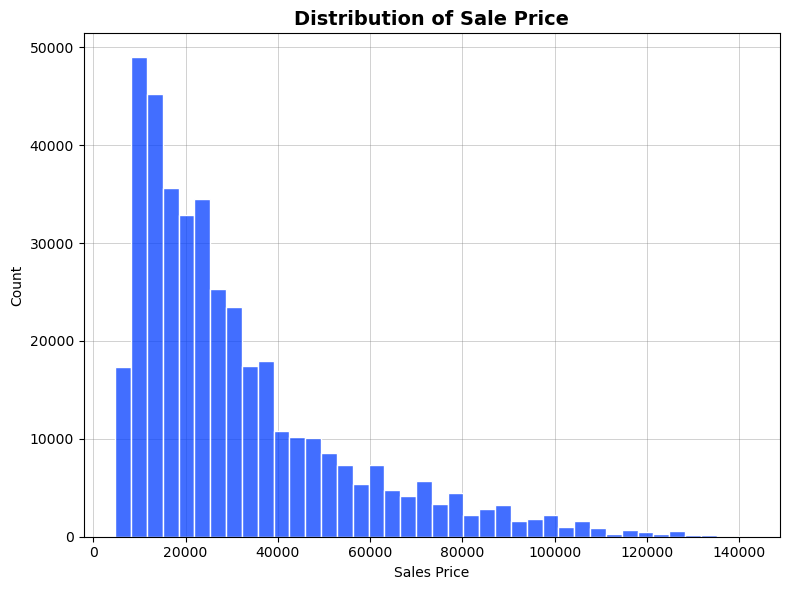

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(train_eda.SalePrice, color="b", edgecolor="white", ax=ax, bins=40)
ax.set(xlabel="Sales Price", ylabel="Count")
ax.set_title("Distribution of Sale Price", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.5, linewidth=0.5, color="grey")
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin


class DatetimeFeatureExtractor(BaseEstimator, TransformerMixin):
	"""
	Extract temporal features from datetime columns.

	Parameters
	----------
	datetime_columns : list of str
			Columns containing datetime values.
	features : list of str
			Features to extract: 'saleYear', 'saleMonth', 'saleDay',
			'saleDayofweek', 'saleDayofyear'.
	drop_original : bool, default=True
			Whether to drop original datetime columns.
	"""

	def __init__(self, datetime_columns: list, features=None, drop_original: bool = True):
		# __init__ only stores parameters, no data processing
		# This allows the transformer to be cloned and used in pipelines/cross-validation

		# Check type before doing any work (fail-fast principle)
		# This prevents confusing errors later in fit() or transform()
		if not isinstance(datetime_columns, list):
			raise TypeError(f"datetime_columns must be a list, got {type(datetime_columns).__name__}")
		if not datetime_columns:
			raise ValueError("datetime_columns cannot be empty")
		if not all(isinstance(col, str) for col in datetime_columns):
			raise TypeError("All items in datetime_columns must be strings")

		# Store the columns we want to process
		self.datetime_columns = datetime_columns

		# If user doesn't specify, we extract these temporal features
		# These capture cyclical patterns: yearly trends, seasonal effects, weekly patterns
		self.features = features or ["SaleYear", "SaleMonth", "SaleDay", "SaleDayofWeek", "SaleDayofYear"]

		# Ensure user only requests valid features
		# This prevents typos and clarifies what extractions are supported
		valid_features = {"SaleYear", "SaleMonth", "SaleDay", "SaleDayofWeek", "SaleDayofYear"}
		invalid_features = set(self.features) - valid_features
		if invalid_features:
			raise ValueError(f"Invalid features: {invalid_features}. Valid options: {valid_features}")

		# Option to drop original datetime column to save memory
		# Useful when we only need extracted features, not the original timestamps
		self.drop_original = drop_original

	def fit(self, X, y=None):
		# fit() learns from the data (though this transformer doesn't learn anything)
		# The y parameter is ignored but required for sklearn pipeline compatibility

		# Check inputs before attempting any processing
		# This provides clear error messages at the start of the pipeline
		if X is None:
			raise ValueError("X cannot be None")
		if not isinstance(X, pd.DataFrame):
			raise TypeError(f"X must be a pandas DataFrame, got {type(X).__name__}")

		# Verify that the columns we need actually exist
		# This catches configuration errors before transform() is called on new data
		missing_cols = set(self.datetime_columns) - set(X.columns)
		if missing_cols:
			raise ValueError(f"Datetime columns not found in DataFrame: {missing_cols}")

		# fit() must return self to enable method chaining
		# transformer.fit(X).transform(X)
		return self

	def transform(self, X):
		# transform() applies the transformation to data
		# This is called after fit(), or during pipeline.transform()

		# Validate inputs even in transform (data might come from different source)
		if X is None:
			raise ValueError("X cannot be None")
		if not isinstance(X, pd.DataFrame):
			raise TypeError(f"X must be a pandas DataFrame, got {type(X).__name__}")

		# Create a copy to avoid modifying the original DataFrame
		# This prevents unexpected side effects and follows sklearn best practices
		X = X.copy()

		# Extract temporal features from each specified column
		for col in self.datetime_columns:
			# Ensure column still exists (in case schema changed)
			if col not in X.columns:
				raise ValueError(f"Column '{col}' not found in DataFrame during transform")

			# Convert string/object to pandas datetime for feature extraction
			# errors='coerce' converts invalid dates to NaT (Not a Time) instead of raising errors
			try:
				dt = pd.to_datetime(X[col], errors="coerce")
			except Exception as e:
				raise ValueError(f"Failed to convert column '{col}' to datetime: {str(e)}")

			# Warn if conversion produced missing values
			# NaT values indicate invalid dates that couldn't be parsed
			nat_count = dt.isna().sum()
			if nat_count > 0:
				print(f"Warning: {nat_count} NaT values found in '{col}' after datetime conversion")

			# Define how to extract each temporal feature
			feature_map = {
				"SaleYear": dt.dt.year,
				"SaleMonth": dt.dt.month,
				"SaleDay": dt.dt.day,
				"SaleDayofWeek": dt.dt.dayofweek,
				"SaleDayofYear": dt.dt.dayofyear,
			}

			# Add each requested feature as a new column
			# This expands the feature space with interpretable temporal information
			for feat in self.features:
				if feat in feature_map:
					X[feat] = feature_map[feat]

			# Optionally remove the original datetime column
			# Reduces memory usage and removes non-numeric data for models
			if self.drop_original:
				X = X.drop(columns=[col])

		# transform() returns the transformed DataFrame
		# transformer.transform(X).some_other_method()
		return X

In [12]:
from sklearn.pipeline import Pipeline

date_transform = Pipeline(steps=[("date_extractor", DatetimeFeatureExtractor(datetime_columns=["saledate"], drop_original=False))])

In [13]:
train_eda = date_transform.fit_transform(train_eda)

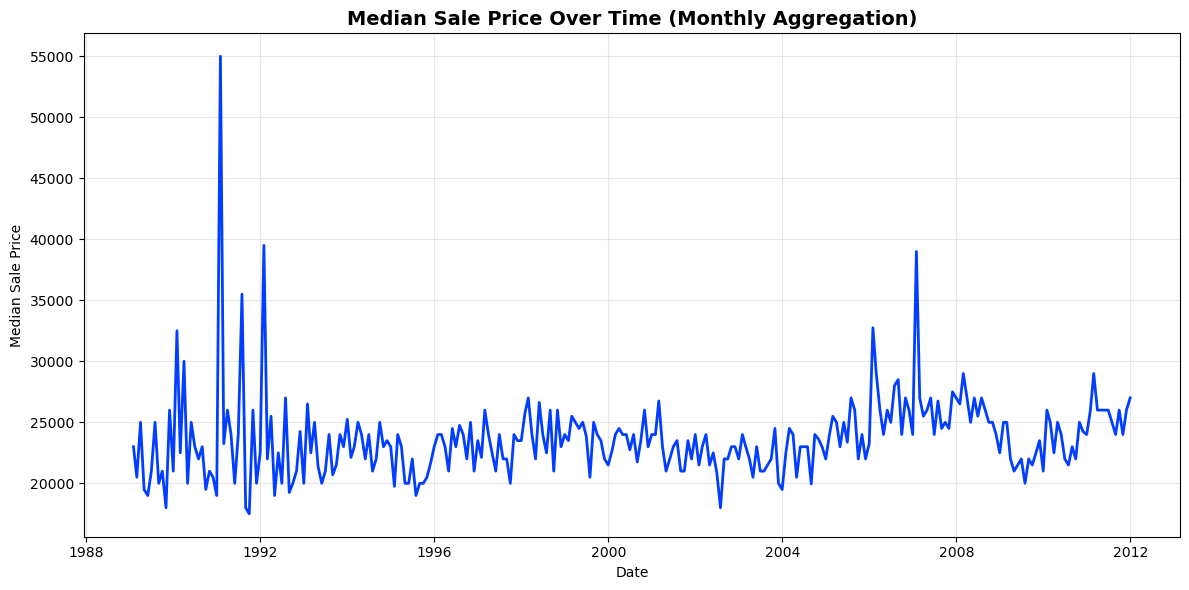

In [14]:
# Sort by date for proper time-series plotting
train_eda = train_eda.sort_values("saledate")

monthly_prices = train_eda.set_index("saledate")["SalePrice"].resample("ME").median()

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=monthly_prices.index, y=monthly_prices, color="b", linewidth=2)

ax.set_title("Median Sale Price Over Time (Monthly Aggregation)", fontsize=14, fontweight="bold")
ax.set_ylabel("Median Sale Price")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

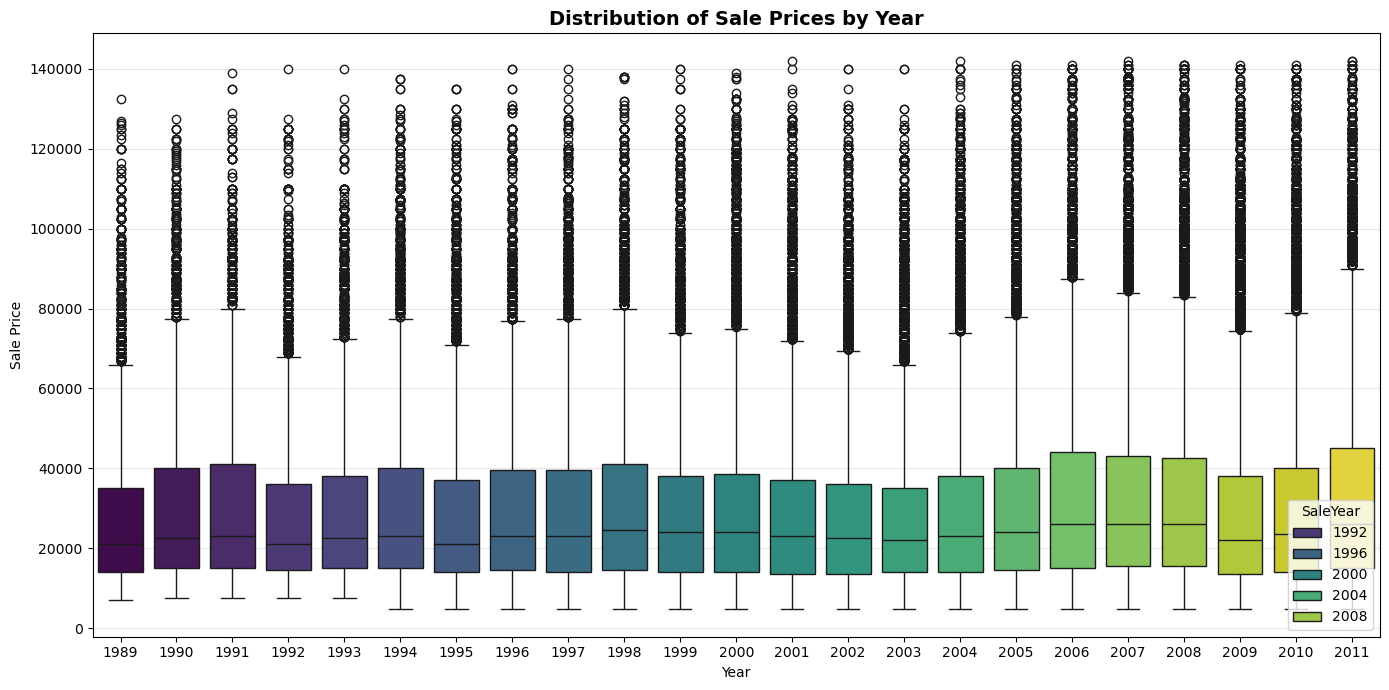

In [15]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.boxplot(data=train_eda, x="SaleYear", y="SalePrice", ax=ax, palette="viridis", hue="SaleYear")

ax.set_title("Distribution of Sale Prices by Year", fontsize=14, fontweight="bold")
ax.set_xlabel("Year")
ax.set_ylabel("Sale Price")
ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### Discussing possible ways to handle missing values

For missing numeric values, some potential options are:

| **Method** | **Pros**  | **Cons** |
|-----|-----|-----|
| **Fill with mean of column** | - Easy to calculate/implement <br> - Retains overall data distribution | - Averages out variation <br> - Affected by outliers (e.g. if one value is much higher/lower than others) |
| **Fill with median of column** | - Easy to calculate/implement <br> - Robust to outliers <br> - Preserves center of data  | - Ignores data distribution shape |
| **Fill with mode of column** | - Easy to calculate/implement <br> - More useful for categorical-like data | - May not make sense for continuous/numerical data  |
| **Fill with 0 (or another constant)** | - Simple to implement <br> - Useful in certain contexts like counts  | - Introduces bias (e.g. if 0 was a value that meant something) <br> - Skews data (e.g. if many missing values, replacing all with 0 makes it look like that's the most common value)  |
| **Forward/Backward fill (use previous/future values to fill future/previous values)**  | - Maintains temporal continuity (for time series) | - Assumes data is continuous, which may not be valid |
| **Use a calculation from other columns** | - Takes existing information and reinterprets it | - Can result in unlikely outputs if calculations are not continuous | 
| **Interpolate  (e.g. like dragging a cell in Excel/Google Sheets)** | - Captures trends <br> - Suitable for ordered data | - Can introduce errors <br> - May assume linearity (data continues in a straight line) |
| **Drop missing values** | - Ensures complete data (only use samples with all information) <br> - Useful for small datasets | - Can result in data loss (e.g. if many missing values are scattered across columns, data size can be dramatically reduced) <br> - Reduces dataset size  |




### Imputing the missing values with the median of the column

In [16]:
from sklearn.impute import SimpleImputer

# Select only numerical columns for imputation
numerical_cols = train_eda.select_dtypes(include=[np.number]).columns
median_imputer = SimpleImputer(missing_values=np.nan, strategy="median", add_indicator=True)
numerical_imputed = median_imputer.fit_transform(train_eda[numerical_cols])

# Create a DataFrame for the imputed numerical data (including indicator columns)
# The imputer adds indicator columns for each column that had missing values
imputed_df = pd.DataFrame(numerical_imputed, columns=median_imputer.get_feature_names_out(numerical_cols), index=train_eda.index)

# Update the original DataFrame with the imputed numerical columns
train_eda[numerical_cols] = imputed_df[numerical_cols]

# Add the indicator columns to the DataFrame
indicator_cols = [col for col in imputed_df.columns if col not in numerical_cols]
train_eda[indicator_cols] = imputed_df[indicator_cols]

In [17]:
train_eda.isna().sum().sort_values(ascending=False)

Enclosure_Type                               375906
Tip_Control                                  375906
Blade_Width                                  375906
Engine_Horsepower                            375906
Pushblock                                    375906
Blade_Extension                              375906
Scarifier                                    375895
Hydraulics_Flow                              357763
Grouser_Tracks                               357763
Coupler_System                               357667
fiModelSeries                                344217
Steering_Controls                            331756
Differential_Type                            331714
UsageBand                                    331486
fiModelDescriptor                            329206
Backhoe_Mounting                             322453
Stick                                        321991
Turbocharged                                 321991
Pad_Type                                     321991
Blade_Type  

In [18]:
from typing import Iterable, Optional

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted


class CategoricalToCodesWithMissing(BaseEstimator, TransformerMixin):
	"""
	Turn non-numeric columns into integer codes (1..K), reserving 0 for missing/unknown.
	Optionally adds a per-column missing indicator column.

	- fit() stores the categories observed in training for each categorical column
	- transform() uses those stored categories so codes are consistent across datasets
	- missing/unknown -> code 0

	This transformer follows sklearn's API conventions:
	- Inherits from BaseEstimator (enables get_params/set_params for hyperparameter tuning)
	- Inherits from TransformerMixin (provides fit_transform method automatically)
	- Implements fit() to learn from training data
	- Implements transform() to apply learned mappings to new data
	"""

	def __init__(
		self,
		columns: Optional[Iterable[str]] = None,
		*,
		add_missing_indicator: bool = True,
		missing_suffix: str = "_is_missing",
		handle_unknown: str = "zero",  # "zero" or "error"
		missing_indicator_as_int: bool = True,
		return_dataframe: bool = True,
	) -> None:
		"""
		Initialize the transformer with configuration parameters.

		Parameters are stored as instance attributes (sklearn convention).
		These attributes should NOT end with underscore - those are reserved
		for attributes learned during fit().
		"""
		self.columns = columns
		self.add_missing_indicator = add_missing_indicator
		self.missing_suffix = missing_suffix
		self.handle_unknown = handle_unknown
		self.missing_indicator_as_int = missing_indicator_as_int
		self.return_dataframe = return_dataframe

	@staticmethod
	def _is_numeric(series: pd.Series) -> bool:
		"""
		Helper method to check if a pandas Series contains numeric data.
		Static method since it doesn't need access to instance state.
		"""
		return pd.api.types.is_numeric_dtype(series)

	def fit(self, X: pd.DataFrame, y: object = None) -> "CategoricalToCodesWithMissing":
		"""
		Learn the categorical mappings from the training data.

		In sklearn's API:
		- fit() learns parameters from training data
		- Learned attributes must end with underscore (e.g., categories_by_column_)
		- Must return self to enable method chaining
		- The 'y' parameter is included for sklearn compatibility but not used here

		This method:
		1. Validates input data type
		2. Identifies which columns are categorical
		3. Stores the unique categories seen in each categorical column
		"""
		# Validate that input is a pandas DataFrame
		if not isinstance(X, pd.DataFrame):
			raise TypeError(f"{self.__class__.__name__} expects a pandas DataFrame, got {type(X)}.")

		# Validate the handle_unknown parameter
		if self.handle_unknown not in {"zero", "error"}:
			raise ValueError("handle_unknown must be 'zero' or 'error'.")

		# Determine which columns to treat as categorical
		# If no columns specified, auto-detect non-numeric columns
		if self.columns is None:
			categorical_columns = [col for col in X.columns if not self._is_numeric(X[col])]
		else:
			# If columns are specified, validate they exist in the DataFrame
			categorical_columns = list(self.columns)
			missing = [col for col in categorical_columns if col not in X.columns]
			if missing:
				raise ValueError(f"columns not found in input DataFrame: {missing}")

		# Learn the categories for each categorical column
		# This is the "fitting" step - storing training data information
		categories_by_column: dict[str, pd.Index] = {}
		for column_name in categorical_columns:
			# Use pandas' Categorical to infer unique categories
			# This handles the category ordering consistently
			learned = pd.Categorical(X[column_name]).categories
			categories_by_column[column_name] = learned

		# Store learned attributes with trailing underscore (sklearn convention)
		# These attributes can be checked with check_is_fitted()
		self.categorical_columns_ = categorical_columns
		self.categories_by_column_ = categories_by_column
		self.feature_names_in_ = np.array(X.columns, dtype=object)

		# Return self to enable method chaining (e.g., fit().transform())
		return self

	def transform(self, X: pd.DataFrame) -> pd.DataFrame | np.ndarray:
		"""
		Apply the learned categorical mappings to transform the data.

		In sklearn's API:
		- transform() applies learned mappings without modifying them
		- Must only use attributes learned in fit() (ending with underscore)
		- Should work on any data with same structure as training data

		This method:
		1. Validates the transformer has been fitted
		2. Creates missing indicator columns (if requested)
		3. Converts categorical values to integer codes using learned categories
		4. Handles unknown categories according to handle_unknown parameter
		"""
		# Verify that fit() has been called before transform()
		# check_is_fitted raises NotFittedError if attributes don't exist
		check_is_fitted(self, attributes=["categorical_columns_", "categories_by_column_"])

		# Validate input type
		if not isinstance(X, pd.DataFrame):
			raise TypeError(f"{self.__class__.__name__} expects a pandas DataFrame, got {type(X)}.")

		# Create a copy to avoid modifying the original data
		X_out = X.copy()

		# Process each categorical column
		for column_name in self.categorical_columns_:
			original = X_out[column_name]

			# Create missing indicator column BEFORE encoding
			# This captures true missing values in the original data
			if self.add_missing_indicator:
				missing_mask = original.isna()
				# Convert to int8 or keep as boolean based on parameter
				indicator = missing_mask.astype(np.int8) if self.missing_indicator_as_int else missing_mask
				X_out[f"{column_name}{self.missing_suffix}"] = indicator

			# Get the categories learned during fit()
			known_categories = self.categories_by_column_[column_name]

			# If handle_unknown is "error", check for unknown categories
			if self.handle_unknown == "error":
				non_missing = original.dropna()
				# Find values that weren't seen during training
				unknown_values = non_missing[~non_missing.isin(known_categories)]
				if not unknown_values.empty:
					sample = unknown_values.unique()[:10].tolist()
					raise ValueError(f"Unknown categories found in column '{column_name}'. Examples: {sample}")

			# Convert to categorical codes using the learned categories
			# pd.Categorical forces the use of known_categories only
			# Unknown values (not in known_categories) become NaN
			categorical = pd.Categorical(original, categories=known_categories)

			# categorical.codes returns:
			# -1 for missing/unknown values
			# 0, 1, 2, ... for the known categories
			# We add 1 to shift the range:
			# -1 -> 0 (missing/unknown)
			# 0 -> 1 (first category)
			# 1 -> 2 (second category), etc.
			codes = categorical.codes + 1
			X_out[column_name] = codes.astype(np.int64)

		# Return DataFrame or numpy array based on parameter
		if self.return_dataframe:
			return X_out

		return X_out.to_numpy()

	def get_feature_names_out(self, input_features: Optional[Iterable[str]] = None) -> np.ndarray:
		"""
		Get the names of output features after transformation.

		This is a sklearn convention for transformers that modify feature names.
		It's used by Pipeline to track feature names through multiple transformations.

		Returns feature names including any added missing indicator columns.
		"""
		# Verify the transformer has been fitted
		check_is_fitted(self, attributes=["categorical_columns_"])

		# Use stored feature names if none provided
		if input_features is None:
			input_features_list = list(self.feature_names_in_)
		else:
			input_features_list = list(input_features)

		# Build list of output feature names
		output_features: list[str] = []
		for feature_name in input_features_list:
			# Original feature is always included
			output_features.append(feature_name)

			# Add missing indicator column name if applicable
			if self.add_missing_indicator and feature_name in set(self.categorical_columns_):
				output_features.append(f"{feature_name}{self.missing_suffix}")

		return np.array(output_features, dtype=object)


### Loading the Validation Set

In [19]:
valid_url = "https://media.githubusercontent.com/media/jhlopesalves/classic_workflows/main/supervised_learning/regression/bulldozer/data/Valid.csv"
valid = pd.read_csv(valid_url, low_memory=False)

In [22]:
train

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,10500,1840702,21439,149,1.0,2005,NaN,NaN,2011-11-02,35NX2,35,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Maryland,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401121,6333337,11000,1830472,21439,149,1.0,2005,NaN,NaN,2011-11-02,35NX2,35,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Maryland,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401122,6333338,11500,1887659,21439,149,1.0,2005,NaN,NaN,2011-11-02,35NX2,35,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Maryland,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401123,6333341,9000,1903570,21435,149,2.0,2005,NaN,NaN,2011-10-25,30NX,30,NX,NaN,NaN,M

In [ ]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

# Split data by date (temporal split to avoid data leakage)
# Training: data through end of 2011
# Validation: January 1, 2012 - April 30, 2012
train_mask = train["saledate"] <= "2011-12-31"
valid_mask = (train["saledate"] >= "2012-01-01") & (train["saledate"] <= "2012-04-30")

train_df = train[train_mask].copy()
valid_df = train[valid_mask].copy()

print(f"Training set: {len(train_df)} samples (through end of 2011)")
print(f"Validation set: {len(valid_df)} samples (Jan 1, 2012 - Apr 30, 2012)")

# Define datetime columns
datetime_cols = ["saledate"]

# Create the full preprocessing pipeline
preprocessing_pipeline = Pipeline(
	steps=[
		# Step 1: Extract datetime features from saledate
		(
			"datetime_features",
			DatetimeFeatureExtractor(
				datetime_columns=datetime_cols,
				features=["SaleYear", "SaleMonth", "SaleDay", "SaleDayofWeek", "SaleDayofYear"],
				drop_original=True,
			),
		),
		# Step 2: Apply transformations to numerical and categorical columns
		(
			"column_transforms",
			ColumnTransformer(
				transformers=[
					# Median imputation for numerical columns with missing indicators
					(
						"numerical_imputer",
						SimpleImputer(missing_values=np.nan, strategy="median", add_indicator=True),
						make_column_selector(dtype_include=np.number),
					),
					# Convert categorical columns to integer codes
					(
						"categorical_encoder",
						CategoricalToCodesWithMissing(add_missing_indicator=True),
						make_column_selector(dtype_exclude=np.number),
					),
				],
				remainder="passthrough",
				verbose_feature_names_out=False,
			),
		),
	]
)

# Separate features and target
X_train_raw = train_df.drop(columns=["SalePrice"])
y_train = train_df["SalePrice"]

X_valid_raw = valid_df.drop(columns=["SalePrice"])
y_valid = valid_df["SalePrice"]

# Fit the pipeline on training data and transform both sets
preprocessing_pipeline.fit(X_train_raw)

X_train = preprocessing_pipeline.transform(X_train_raw)
X_valid = preprocessing_pipeline.transform(X_valid_raw)

print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")

KeyError: "['SalePrice'] not found in axis"